# Regression using random forest

This example is adapted from an article [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0). In this problem we want to predict the maximum temperature for any day in Sydney based on historical data from 2017. Temperature and precipitation data for Sydney may be accessed from [here](https://www.ncdc.noaa.gov/cdo-web/). For convenience we have downloaded the data in comma-separated-variable (CSV) format and placed it in ```DATA/temps.csv```.

Our workflow for this section is:

 1. Load the data into a Pandas dataframe
 1. Clean the data as required
 1. Prepare the data for ingestion by the machine learning system
 1. Train the model and visualise the training and results
 1. Make predictions against a test dataset and assess performance
 1. Adjust hyperparameters and retrain
 1. Visualise results

### 1) Load the data into a dataframe

A dataframe is a container for tabular data similar to a spreadsheet. It has unique and useful indexing and querying properties.

In [1]:
# Import the Pandas module
import pandas as pd

# Load the data
features = pd.read_csv('DATA/temps.csv')

# Print the dimensions (shape) of the table
print("Table dimensions [rows, columns]:", features.shape)

# Display the first 5 rows
features.head(5)

Table dimensions [rows, columns]: (348, 12)


,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [2]:
# Display the last 5 rows
features.tail(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42
347,2016,12,31,Sat,48,57,45.5,40,42,48,47,57


The key columns for our analysis are:

 * temp_2: max temperature 2 days prior
 * temp_1: max temperature 1 day prior
 * average: historical average max temperature
 * actual: max temperature measurement
 * friend: your friend’s prediction, a random number between 20 below the average and 20 above the average
 
It is useful now to examine simple statistics for each column:

### 2) Clean the data

It is useful now to examine simple statistics for each column:

In [3]:
# Print descriptive stats for each column
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


The statistics of the data don't show any unusual outliers.

Next we want to plot the data for a visual examination. For convenience we will make a function that creates a nicely formatted plot with date on the x-axis and temperature on the y-axis.

In [4]:
# Necessary imports and magic command to display plots inline
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


def plot_trend_ax(ax, df, columnNames = ['actual'], yLabel='Temperature'):
    """Plot multiple trend lines over each other"""
    
    # Select columns years, months and days
    years = df['year'].astype(str)
    months = df['month'].astype(str)
    days = df['day'].astype(str)
    
    # Convert dates to a datetime object
    dateStrLst = ["-".join(x) for x in zip(years, months, days)]
    dates = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in dateStrLst]
    
    # Plot the data
    for colName in columnNames:
        ax.step(dates, df[colName], where='mid', label=colName, linewidth=1)
    ax.set_ylabel('Date')
    ax.set_ylabel(yLabel)
    ax.tick_params(axis='x', rotation=45)
    
    # Enable the legend
    ax.legend(loc='best')
    
    return ax    

/home/cpurcell/.virtualenvs/dl4cv/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


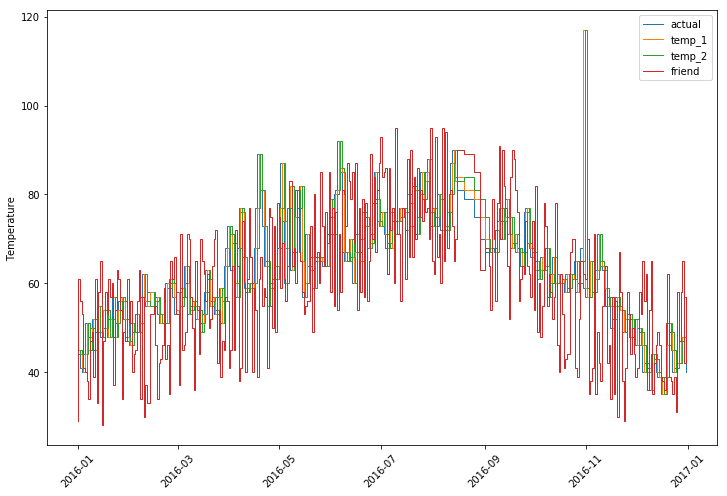

In [5]:
# Initialise the figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Plot 
plot_trend_ax(ax, features, columnNames=['actual', 'temp_1', 'temp_2', 'friend'])

### 3) Preparing the data for the ML algorithm

We will be using an implementation of the Random Forest algorithm within *scikit-learn*. Most machine learning algorithms require *catagorical data* to be encoded as a binary vector. For example, a column containing days of the week ```['Mon', 'Tue', 'Wed' ...]``` would be converted to a set of new columns that looks like this:

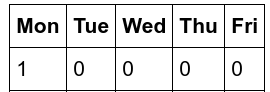

This is known as *one-hot encoding* and is simply a vector where the current catagory is indicated by a '1'. Pandas has a built-in function to convert all catagorical variables to new 'one-hot' columns:

In [6]:
# One-hot encode categorical variables
features = pd.get_dummies(features)

# Show the first 5 rows of the table
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


Note that the other columns (e.g., month, day) are already in numerical format and so are not converted.

The goal of this excersise is to predict the actual temperature using the other columns in the dataset. We want to split out the 'actual' column and put it in a separate array. 

In [7]:
# Use numpy to create a new array from the 'actual' column
import numpy as np
labels = np.array(features['actual'])

# Delete the 'actual' column from the table (axis=1 means drop column, not row)
features = features.drop('actual', axis = 1)

Scikit-learn does not accept pandas dataframes, so we want to convert the table into a standard Numpy array that contains only numerical values. During this process the column names will be lost, so we save these as a separate list

In [8]:
# Save a list of column headers
feature_list = list(features.columns)
print(feature_list)

['year', 'month', 'day', 'temp_2', 'temp_1', 'average', 'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend', 'week_Fri', 'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed']


In [9]:
# Convert the table to a numpy array
features = np.array(features)
print(features)

[[2.016e+03 1.000e+00 1.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.016e+03 1.200e+01 2.900e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.200e+01 3.000e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.200e+01 3.100e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


**Training and Test data**

In supervised learning we want to set aside some data as an 'independent' dataset to test our predictions. This is usually some randomly-chosen fraction of the input data. Scikit-learn has a convenience function to make this split easy:

In [10]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split 25% of the data into a test set
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size=0.25, random_state=42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


### 4) Train the model

In [11]:
# Import the specific algorithm 
from sklearn.ensemble import RandomForestRegressor

# Create an instance of the model with 1000 estimators
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

/home/cpurcell/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


### 5) Assess the performance of the model

In [13]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.94 %.


### 6) Adjusting the model

In [14]:
rf_new = RandomForestRegressor(n_estimators = 100, 
                               criterion = 'mse', 
                               max_depth = None, 
                               min_samples_split = 2, 
                               min_samples_leaf = 1)

### 7) Visualising

In [15]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png');

ModuleNotFoundError: No module named 'pydot'

In [ ]:
print('The depth of this tree is:', tree.tree_.max_depth)


Create a smaller tree for visualization.

In [ ]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

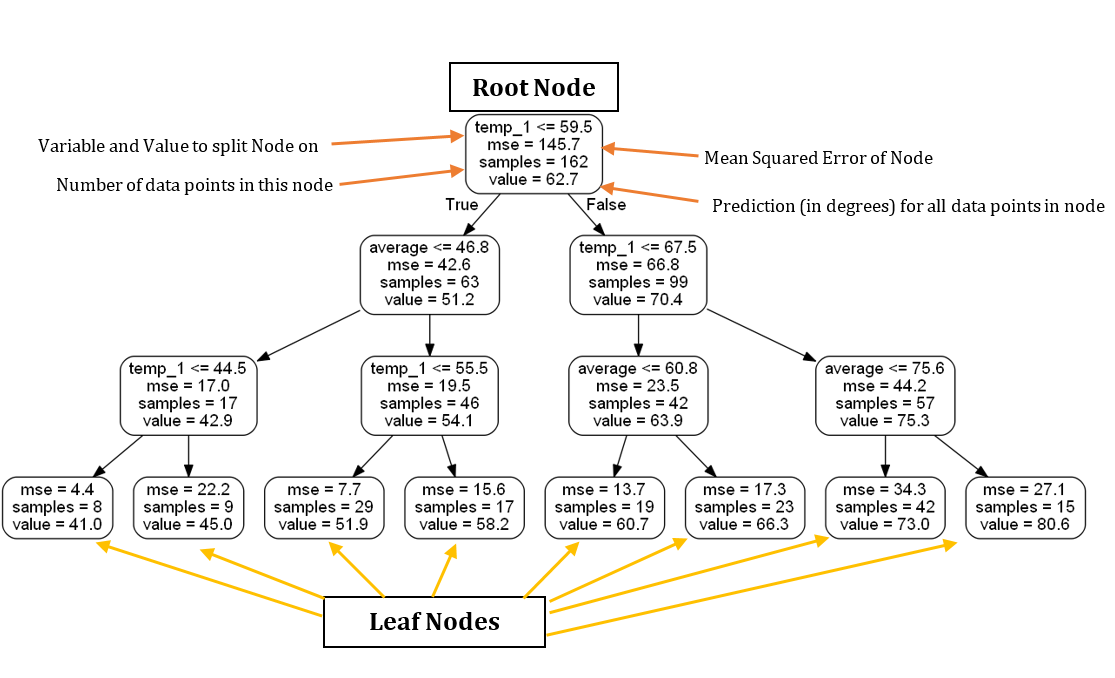

**Assess variable importance**


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


**Model with 2 most important features only**

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

### 8) Visualisations

In [ ]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

In [ ]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


In [ ]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');
